# Анализ бизнес-показателей

<b>Цель:</b>
- помочь развлекательному приложению Procrastinate Pro+ выйти в плюс

<b>Задачи:</b>
- разобраться в причинах убытков;
- изучить откуда приходят пользователи и какими устройствами они пользуются,
- выяснить сколько стоит привлечение пользователей из различных рекламных каналов;
- выяснить сколько денег приносит каждый клиент,
- выяснить когда расходы на привлечение клиента окупаются,
- выяснить какие факторы мешают привлечению клиентов.

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

<b>Ход исследования:</b>
1. [Загрузка данных и подготовка их к анализу](#import)
2. [Создание функции для расчёта и анализа LTV, ROI, удержания и конверсии](#function)
3. [Исследовательский анализ данных](#analysis)
4. [Маркетинг](#marketing)
5. [Оценка окупаемость рекламы](#commercial)
6. [Выводы](#conclusion)

<a id="import"> </a>
# 1. Загрузка данных и подготовка их к анализу

Загрузите данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

**Пути к файлам**

- визиты: `/datasets/visits_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/visits_info_short.csv);
- заказы: `/datasets/orders_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/orders_info_short.csv);
- расходы: `/datasets/costs_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/costs_info_short.csv).

Изучите данные и выполните предобработку. Есть ли в данных пропуски и дубликаты? Убедитесь, что типы данных во всех колонках соответствуют сохранённым в них значениям. Обратите внимание на столбцы с датой и временем.

In [131]:
# импорт библиотек

import pandas as pd
import numpy as np

from datetime import datetime, timedelta

from matplotlib import pyplot as plt
import seaborn as sns

In [132]:
# загрузка данных

visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

In [133]:
# Общая информация о visits

visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [134]:
visits.head(5)

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [135]:
# Проверка и удаление дубликатов в таблице visits

visits.duplicated().sum()

0

In [136]:
visits = visits.drop_duplicates()

In [137]:
# Общая информация об orders

orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [138]:
orders.head(5)

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [139]:
# Проверка и удаление дубликатов в таблице orders

orders.duplicated().sum()

0

In [140]:
orders = orders.drop_duplicates()

In [141]:
# Общая информация о costs

costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [142]:
costs.head(5)

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [143]:
# Проверка и удаление дубликатов в таблице costs

costs.duplicated().sum()

0

In [144]:
costs = costs.drop_duplicates()

Необходимо изменить типы данных в:
- колонках 'Session Start', 'Session End' таблицы 'visits',
- колонке 'Event Dt' таблицы 'orders',
- колонке 'dt' таблицы costs.

In [145]:
# изменяем тип данных

visits['Session Start'] = pd.to_datetime(visits['Session Start'])
visits['Session End'] = pd.to_datetime(visits['Session End'])

orders['Event Dt'] = pd.to_datetime(orders['Event Dt'])

costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

In [146]:
# Переименуем колонки для дальнейшего удобства

visits = visits.rename(columns={'User Id': 'user_id', 'Region': 'region', 'Device': 'device', 'Channel': 'channel', 
                       'Session Start': 'session_start', 'Session End': 'session_end'})

orders = orders.rename(columns={'User Id': 'user_id', 'Event Dt': 'event_dt', 'Revenue': 'revenue'})

costs = costs.rename(columns={'Channel': 'channel'})

Для исследования доступны три датасета:
- visits хранит лог сервера с информацией о посещениях сайта, 
- orders — информацию о заказах, 
- costs — информацию о расходах на рекламу.


Структура visits:
- User Id — уникальный идентификатор пользователя,
- Region — страна пользователя,
- Device — тип устройства пользователя,
- Channel — идентификатор источника перехода,
- Session Start — дата и время начала сессии,
- Session End — дата и время окончания сессии.


Структура orders:
- User Id — уникальный идентификатор пользователя,
- Event Dt — дата и время покупки,
- Revenue — сумма заказа.


Структура costs:
- dt — дата проведения рекламной кампании,
- Channel — идентификатор рекламного источника,
- costs — расходы на эту кампанию.

В имеющихся датафреймах пропущенных значений нет. Дубликатов нет.

<a id="function"> </a>
# 2. Создание функции для расчёта и анализа LTV, ROI, удержания и конверсии

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

# 2.1. Задаем функции для вычисления значений метрик.

In [147]:
# создадим функцию get_profiles() для создания профилей пользователей


def get_profiles(sessions, orders, ad_cost):
    # находим параметры первых посещений
    profiles = (sessions.sort_values(by=['user_id', 'session_start']) \
        .groupby('user_id')
        .agg({'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # определяем дату первого посещения, неделю и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = (ad_costs['costs'] / ad_costs['unique_users']).round(2)

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [148]:
# создадим функцию get_retention() для подсчёта Retention Rate

def get_retention(profiles, sessions, observation_date, horizon_days, dimensions=[], ignore_horizon=False):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(sessions[['user_id', 'session_start']], on='user_id', how='left')
    
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(index=dims, columns='lifetime', values='user_id', aggfunc='nunique')
        
        cohort_sizes = (df.groupby(dims)
                        .agg({'user_id': 'nunique'})
                        .rename(columns={'user_id': 'cohort_size'}))
        
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [149]:
# создадим функцию get_conversion() для подсчёта конверсии

def get_conversion(profiles, purchases, observation_date, horizon_days, dimensions=[], ignore_horizon=False,):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
        
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (purchases.sort_values(by=['user_id', 'event_dt'])
                       .groupby('user_id')
                       .agg({'event_dt': 'first'})
                       .reset_index())

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(first_purchases[['user_id', 'event_dt']], on='user_id', how='left')

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (result_raw['event_dt'] - result_raw['first_ts']).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(index=dims, columns='lifetime', values='user_id', aggfunc='nunique')
        
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (df.groupby(dims)
                        .agg({'user_id': 'nunique'})
                        .rename(columns={'user_id': 'cohort_size'}))
        
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [150]:
# создадим функцию get_ltv() для подсчёта LTV и ROI

def get_ltv(profiles, purchases, observation_date, horizon_days, dimensions=[], ignore_horizon=False):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
        
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left')
    
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (result_raw['event_dt'] - result_raw['first_ts']).dt.days
    
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(index=dims, columns='lifetime', values='revenue', aggfunc='sum')
        
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (df.groupby(dims)
                        .agg({'user_id': 'nunique'})
                        .rename(columns={'user_id': 'cohort_size'}))
        
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (cac.groupby(dims)
               .agg({'acquisition_cost': 'mean'})
               .rename(columns={'acquisition_cost': 'cac'}))

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 


# 2.2. Задаем функции для построения графиков.

In [151]:
# создадим функцию filter_data() для сглаживания данных

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [152]:
# создадим функцию plot_retention() — для построения графика Retention Rate

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [153]:
# создадим функцию plot_conversion() для построения графика конверсии

# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [154]:
# создадим функцию plot_ltv_roi для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 20))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(3, 2, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(3, 2, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(3, 2, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(3, 2, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(3, 2, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

<a id="analysis"> </a>
# 3. Исследовательский анализ данных

- Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.
- Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

После каждого пункта сформулируйте выводы.

In [155]:
# создаем профили пользователей

profiles = get_profiles(visits, orders, costs)
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.09
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.11
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.00
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.99
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.23


In [156]:
# Выделим для удобства платящих клиентов в отдельный датафрейм

profiles_payed = profiles.query('payer==True')

In [157]:
# минимальная дата привлечения пользователей

min_acquisition_date = profiles['first_ts'].min()
min_acquisition_date

Timestamp('2019-05-01 00:00:41')

In [158]:
# Максимальная дата привлечения пользователей

max_acquisition_date = profiles['first_ts'].max()
max_acquisition_date

Timestamp('2019-10-27 23:59:04')

In [159]:
# Построим таблицу, отражающую количество платящих и неплатящих клиентов с разбивкой по странам 

perc_payers = profiles.groupby(['region'])['user_id'].count().reset_index() \
        .merge(profiles_payed.groupby('region')['user_id'].count(), how='left', on='region') \
        .rename(columns={'user_id_x': 'total', 'user_id_y': 'payed'})
perc_payers['perc_%'] = (perc_payers['payed'] / perc_payers['total'] * 100).round(2)

perc_payers.sort_values(by='perc_%', ascending=False, ignore_index=True)

,region,total,payed,perc_%
0,United States,100002,6902,6.90
1,Germany,14981,616,4.11
2,UK,17575,700,3.98
3,France,17450,663,3.80


In [160]:
# Построим таблицу, отражающую количество платящих и неплатящих клиентов с разбивкой по устройствам


perc_device = profiles.groupby(['device'])['user_id'].count().reset_index() \
        .merge(profiles_payed.groupby('device')['user_id'].count(), how='left', on='device') \
        .rename(columns={'user_id_x': 'total', 'user_id_y': 'payed'})
perc_device['perc_%'] = (perc_device['payed'] / perc_device['total'] * 100).round(2)

perc_device.sort_values(by='perc_%', ascending=False, ignore_index=True)

,device,total,payed,perc_%
0,Mac,30042,1912,6.36
1,iPhone,54479,3382,6.21
2,Android,35032,2050,5.85
3,PC,30455,1537,5.05


In [161]:
# Платящие пользователи с разбивкой по странам и устройствам

pd.crosstab(profiles_payed['device'], profiles_payed['region'], margins=False)

region,France,Germany,UK,United States
device,,,,
Android,179,182,202,1487
Mac,82,61,63,1706
PC,268,253,301,715
iPhone,134,120,134,2994


In [162]:
# Построим таблицу, отражающую количество платящих и неплатящих клиентов с разбивкой по каналам привлечения

perc_channel = profiles.groupby(['channel'])['user_id'].count().reset_index() \
        .merge(profiles_payed.groupby('channel')['user_id'].count(), how='left', on='channel') \
        .rename(columns={'user_id_x': 'total', 'user_id_y': 'payed'})
perc_channel['perc_%'] = (perc_channel['payed'] / perc_channel['total'] * 100).round(2)
                    
perc_channel.sort_values(by='perc_%', ascending=False, ignore_index=True)

,channel,total,payed,perc_%
0,FaceBoom,29144,3557,12.20
1,AdNonSense,3880,440,11.34
2,lambdaMediaAds,2149,225,10.47
3,TipTop,19561,1878,9.60
4,RocketSuperAds,4448,352,7.91
5,WahooNetBanner,8553,453,5.30
6,YRabbit,4312,165,3.83
7,MediaTornado,4364,156,3.57
8,LeapBob,8553,262,3.06
9,OppleCreativeMedia,8605,233,2.71


In [163]:
# Платящие пользователи с разбивкой по странам и каналам привлечения

pd.crosstab(profiles_payed['channel'], profiles_payed['region'], margins=False)

region,France,Germany,UK,United States
channel,,,,
AdNonSense,150,142,148,0
FaceBoom,0,0,0,3557
LeapBob,90,69,103,0
MediaTornado,0,0,0,156
OppleCreativeMedia,80,64,89,0
RocketSuperAds,0,0,0,352
TipTop,0,0,0,1878
WahooNetBanner,152,148,153,0
YRabbit,0,0,0,165


In [164]:
# # Платящие пользователи с разбивкой по странам и каналам привлечения (в "процентах")

# pd.crosstab(profiles_payed['channel'], profiles_payed['region'], normalize='columns', margins=False).round(2)

<b>Вывод к разделу:</b>

Мы сформировали датасет profiles с информацией об уникальных пользователях. Датасет охватывает период с 01.05.2019 до 27.10.2019. В датасет вошла информация о канале привлечения пользователя, используемом устройстве, регионе и стоимости привлечения.

Сгруппировав данные о пользователях и стране, мы выяснили, что пользователи приходили из четырех стран - США, Германия, Великобритания и Франция. Абсолютное большинство пользователей приходят из Соединенных штатах - 100 002 пользователей из США против 50 006 пользователей суммарно из оставшихся стран. Несмотря на общее количество, процент платящих клиентов из США 6.9%, из других стран - около 4%.

Сгруппировав данные о пользователях и используемых устройствах, мы выяснили что пользователи пользуются четырьмя типами устройст - PC, Mac, устройства на Android и iPone. Больше всего пользователей используют iPhone (54 479), потом идут пользователи на Android (35 032), пользователей на Mac и PC примерно поровну - 30 042 и 30 455, соответственно. Процент платящих клиентов к общему количеству - больше всего Mac и iPhone (6.36% и 6.21%), следом идут пользователи Android и PC (5.85% и 5.05%, соответственно).

Выполнив группировку платящих пользователей по типу устройства и стране, мы выяснили закономерности:
- для Франции, Германии и Великобритании распредетение между типами устройств одинаковое - больше всего пользователей PC, потом Android, iPhone и Mac,
- для Америки - больше всего пользователей iPhone, потом - Mac и Android, меньше всего - PC.

Такой перекос для Америки объясним особенностями рынка - популярностью устройст apple и непопулярностью домашних компьютеров.


Для привлечения доступно 10 рекламных каналов и органический. Больше всего пользователей пришли из органического канала, Faceboom и TipTop. Проанализировав процент платящей аудитории, мы выяснили, что больше всего пользователей пришли из FaceBoom (12.2%), AdNonSense (11.34%) и lambdaMediaAds (10.47%). TipTop показал 9.6%, органический канал - 2.06%.

Каналы привлечения распределились между странами схожим с устройствами образом:
- мы можем объединить Францию, Германию и Великобританию, где самыми многочисленными каналами стали AdNonSense, WahooNetBanner, LeapBob и органический,
- в Америке амыми многочисленными каналами стали FaceBoom, TipTop и органический.

Для дальнейшей работы стоит иметь в виду особенности рынка этих стран и разделять их на две условные группы - Европа и Америка.

<a id="marketing"> </a>
# 4. Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постарайтесь отразить это на одном графике.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Напишите промежуточные выводы.

In [165]:
# Общая сумма затрат на маркетинг 

costs['costs'].sum().round(2)

105497.3

In [166]:
# Затраты на маркетинг с разбивкой по каналам привлечения

costs.groupby('channel')['costs'].sum()

channel
AdNonSense             3911.25
FaceBoom              32445.60
LeapBob                1797.60
MediaTornado            954.48
OppleCreativeMedia     2151.25
RocketSuperAds         1833.00
TipTop                54751.30
WahooNetBanner         5151.00
YRabbit                 944.22
lambdaMediaAds         1557.60
Name: costs, dtype: float64

In [167]:
# Добавим столбцы week и month для дальнейшей работы

costs['week'] = costs['dt'].astype('datetime64[M]').dt.isocalendar().week
costs['month'] = costs['dt'].astype('datetime64[M]').dt.month

In [168]:
# Создадим сводную таблицу - расходы на различные источники привлечения с разбивкой по неделям

marketing_channel_week = costs.pivot_table(index=['week'], columns='channel', values='costs', aggfunc='sum')
marketing_channel_week 

channel,AdNonSense,FaceBoom,LeapBob,MediaTornado,OppleCreativeMedia,RocketSuperAds,TipTop,WahooNetBanner,YRabbit,lambdaMediaAds
week,,,,,,,,,,
18,1169.70,3524.4,140.28,238.56,169.75,577.980,2981.0,418.8,299.70,458.4
22,538.65,5501.1,314.58,138.00,370.00,325.715,6675.6,921.0,106.20,199.2
27,504.00,5294.3,313.53,138.48,366.50,252.070,8410.2,851.4,97.38,219.2
31,579.60,6274.4,369.81,154.56,439.25,253.110,11202.0,1040.4,124.74,220.0
35,581.70,6114.9,343.98,144.72,427.75,218.400,13232.5,977.4,152.79,247.2
40,537.60,5736.5,315.42,140.16,378.00,205.725,12250.0,942.0,163.41,213.6


In [169]:
# Создадим сводную таблицу - расходы на различные источники привлечения с разбивкой по месяцам

marketing_channel_month = costs.pivot_table(index=['month'], columns='channel', values='costs', aggfunc='sum')
marketing_channel_month

channel,AdNonSense,FaceBoom,LeapBob,MediaTornado,OppleCreativeMedia,RocketSuperAds,TipTop,WahooNetBanner,YRabbit,lambdaMediaAds
month,,,,,,,,,,
5,1169.70,3524.4,140.28,238.56,169.75,577.980,2981.0,418.8,299.70,458.4
6,538.65,5501.1,314.58,138.00,370.00,325.715,6675.6,921.0,106.20,199.2
7,504.00,5294.3,313.53,138.48,366.50,252.070,8410.2,851.4,97.38,219.2
8,579.60,6274.4,369.81,154.56,439.25,253.110,11202.0,1040.4,124.74,220.0
9,581.70,6114.9,343.98,144.72,427.75,218.400,13232.5,977.4,152.79,247.2
10,537.60,5736.5,315.42,140.16,378.00,205.725,12250.0,942.0,163.41,213.6


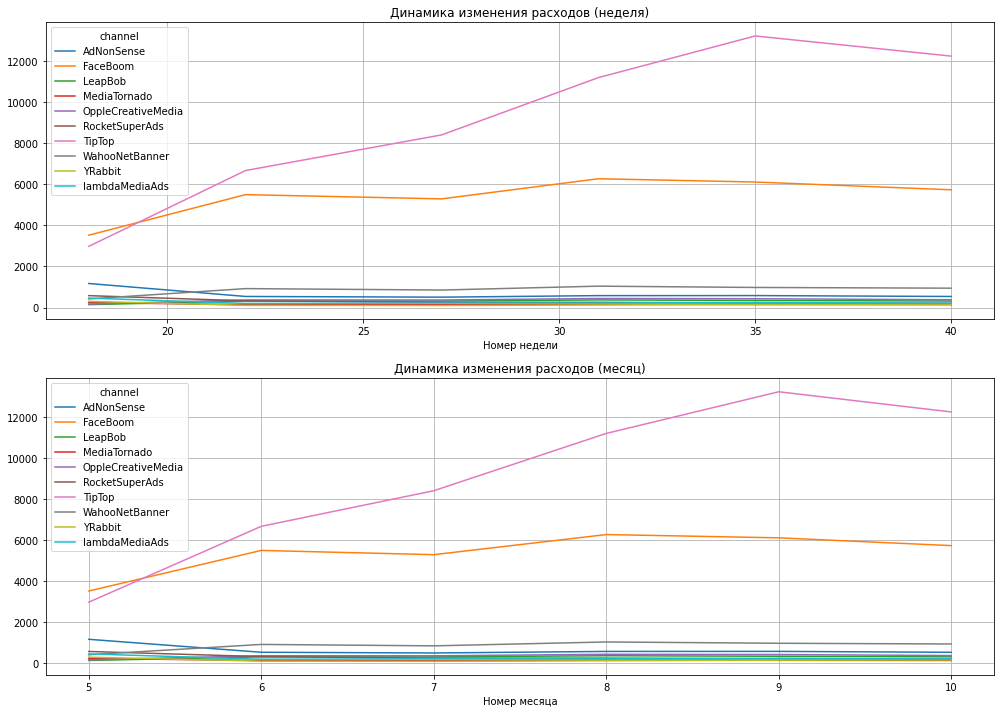

In [170]:
# Построим график расходов на маркетинг с разбивков по источникам

plt.figure(figsize=(17, 12))
ax1 = plt.subplot(2, 1, 1)
marketing_channel_week.plot(grid=True, ax=ax1)
plt.xlabel('Номер недели')
plt.title('Динамика изменения расходов (неделя)')

ax2 = plt.subplot(2, 1, 2)
marketing_channel_month.plot(grid=True, ax=ax2)
plt.xlabel('Номер месяца')
plt.title('Динамика изменения расходов (месяц)')

plt.show()

In [171]:
# Средняя стоимость привлечения с разбивкой по источникам

profiles.groupby('channel')['acquisition_cost'].mean().sort_values(ascending=False).round(2)

channel
TipTop                2.80
FaceBoom              1.11
AdNonSense            1.01
lambdaMediaAds        0.72
WahooNetBanner        0.60
RocketSuperAds        0.41
OppleCreativeMedia    0.25
MediaTornado          0.22
YRabbit               0.22
LeapBob               0.21
organic               0.00
Name: acquisition_cost, dtype: float64

In [172]:
# Средняя стоимость привлечения с разбивкой по странам

profiles.groupby('region')['acquisition_cost'].mean().sort_values(ascending=False).round(2)

region
United States    0.91
Germany          0.30
France           0.29
UK               0.29
Name: acquisition_cost, dtype: float64

In [173]:
# Средняя стоимость привлечения по проекту

profiles['acquisition_cost'].mean().round(2)

0.7

In [174]:
# Средняя стоимость привлечения с разбивкой по устройствам

profiles.groupby('device')['acquisition_cost'].mean().sort_values(ascending=False).round(2)

device
Mac        0.80
iPhone     0.80
Android    0.64
PC         0.50
Name: acquisition_cost, dtype: float64

<b>Вывод к разделу:</b>

Общая сумма средств выделенных на маркетинг - 105 497.30. Эти средства распределены неравномерно:
- больше всего выделено на TipTop (54 751.30), FaceBoom (32 445.60) и WahooNetBanner (5 151),
- на остальные источники выделяется в среднем по ~1 900.

Из предыдущего шага мы помним, что клиенты, приходящие из FaceBoom и TipTop - это клиенты из Америки, которые являются самыми многочисленными пользователями, но доля плятящих клиентов всего 6.9%. WahooNetBanner рассчитан на Европу, приносящую суммарно 11.89% платящих клиентов. Возможно, маркетинговому отделу стоит пересмотреть свою политику и больше денег выделять на WahooNetBanner и прочие сервисы, рассчитанные на привлечение клиентов из Европы.

Построенная нами таблица демонстрирует постоянный рост расходов на FaceBoom и TipTop. Расходы на остальные источники привлечения остается практически без именения.

Средняя стоимость привлечения по проекту - 0.70.

Самые дорогие каналы по средней стоимости привлечения: TipTop - 2.80, FaceBoom - 1.11, AdNonSense - 1.01.

Средняя стоимость привлечения по странам: Америка - 0.91, Европа - ~0.30.

Средняя стоимость привлечения по устройствам: Mac и iPone - 0.80, Android - 0.64, PC - 0.50.

Вывод: 
- меньше денег вкладывать в продвижение через TipTop (невыгодно, мало платящих пользователей),
- больше сосредоточиться на странах Европы - дешевле стоимость привлечения, больше платящих пользователей.

<a id="commercial"> </a>
# 5. Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

In [175]:
# задаем момент анализа - 1 ноября 2019 г. и горизонт анализа - две недели

observation_date = datetime(2019, 11, 1).date()
horizon_days = 14 

# Конверсия

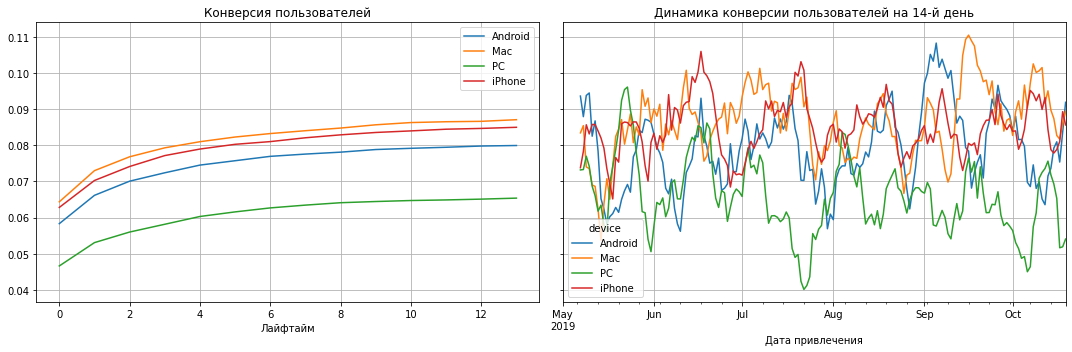

In [178]:
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles.query('channel!="organic"'), orders, observation_date, horizon_days, dimensions=['device'])

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

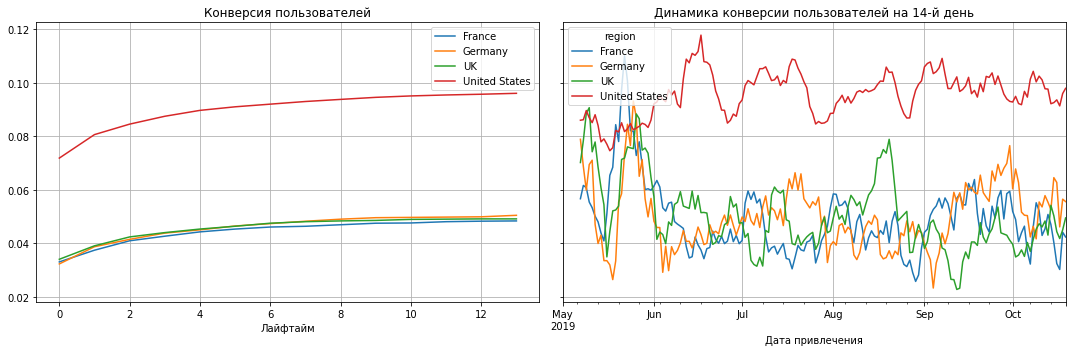

In [179]:
# смотрим конверсию с разбивкой по регионам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles.query('channel!="organic"'), orders, observation_date, horizon_days, dimensions=['region'])

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

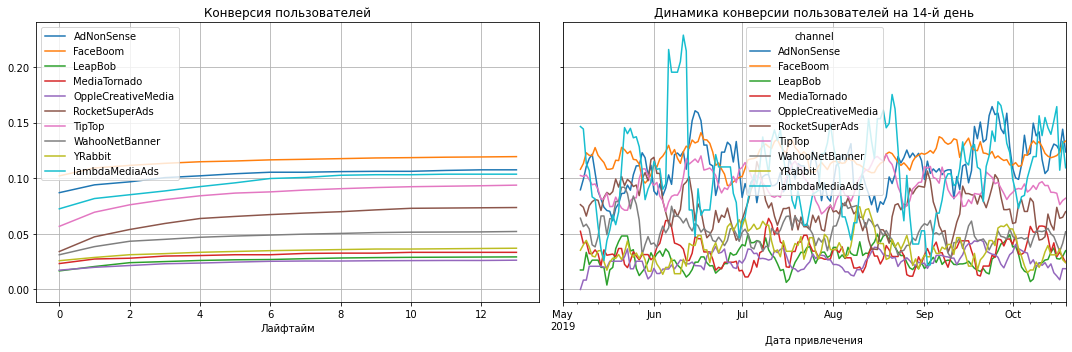

In [180]:
# смотрим конверсию с разбивкой по каналам привлечения

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles.query('channel!="organic"'), orders, observation_date, horizon_days, dimensions=['channel'])

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Лучше всего конверсия пользователей Mac и iPhone, хуже всего - PC. 

Пользователи из Америки конверсируются в разы лучше пользователей из Европы (~0.9 против ~0.5).

По источникам привлечения лучшая конверсия пользователей, привлеченных через FaceBoom и AdNonSence.

# Удержание

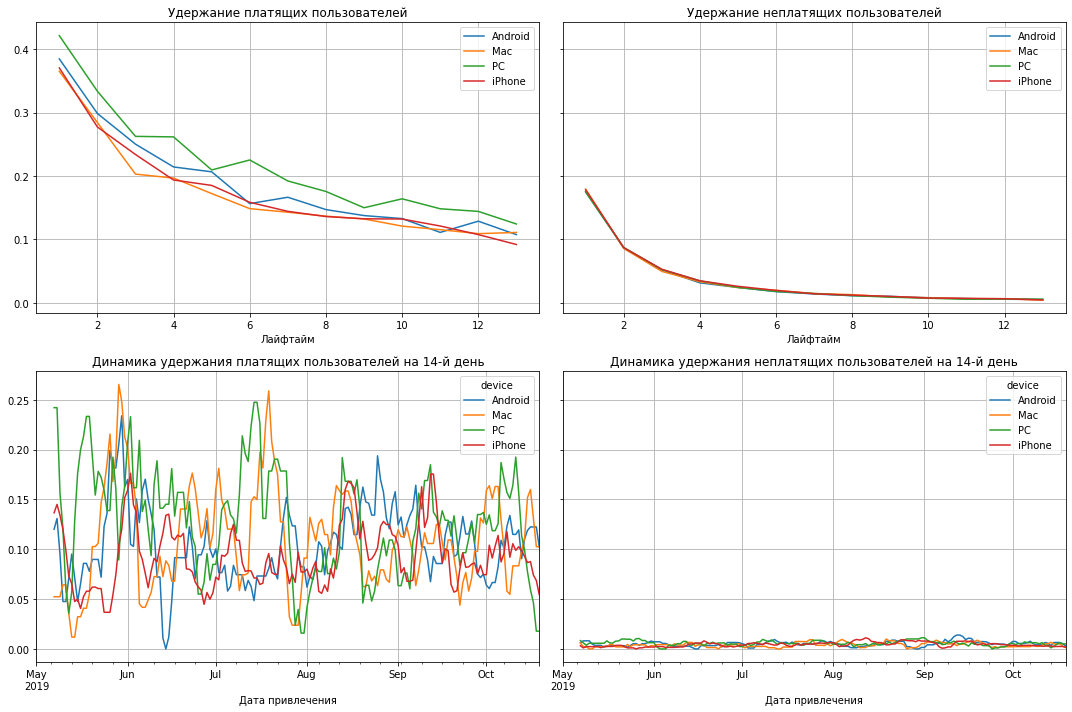

In [181]:
# удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles.query('channel!="organic"'), visits, observation_date, horizon_days, dimensions=['device'])

plot_retention(retention_grouped, retention_history, horizon_days) 

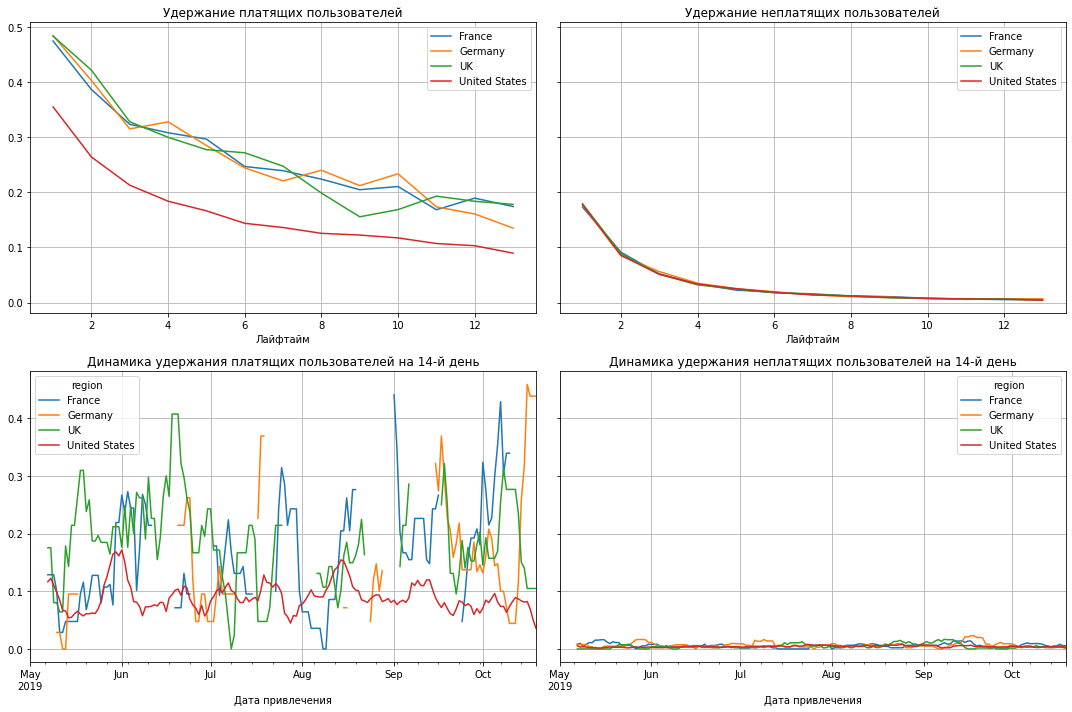

In [182]:
# удержание с разбивкой по регионам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles.query('channel!="organic"'), visits, observation_date, horizon_days, dimensions=['region'])

plot_retention(retention_grouped, retention_history, horizon_days) 

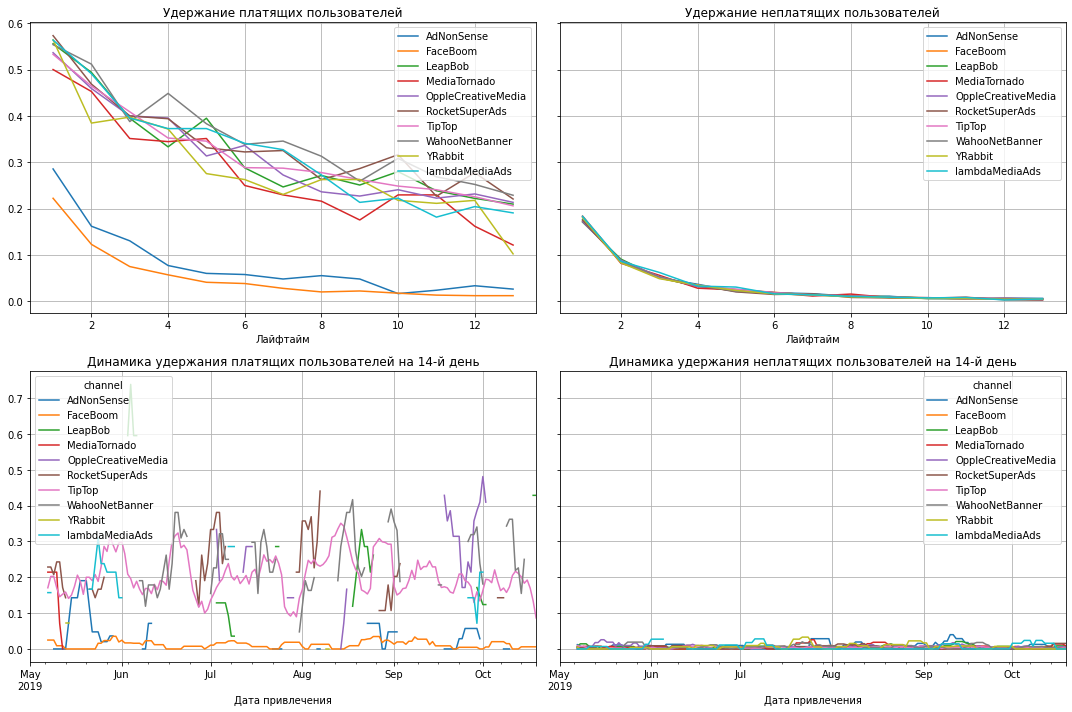

In [183]:
# удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles.query('channel!="organic"'), visits, observation_date, horizon_days, dimensions=['channel'])

plot_retention(retention_grouped, retention_history, horizon_days) 

С удержанием мы наблюдаем противоположную ситуацию - у пользователей PC конверсия была хуже остальных пользователей, но удержание - выше. 

То же самое с разбивкой по странам - конверсия пользователей из Америки выше европейских, но удержание - хуже.

И с источниками привлечения - удержание пользователей из FaceBoom и AdNonSence ниже остальных.

# Окупаемость рекламы

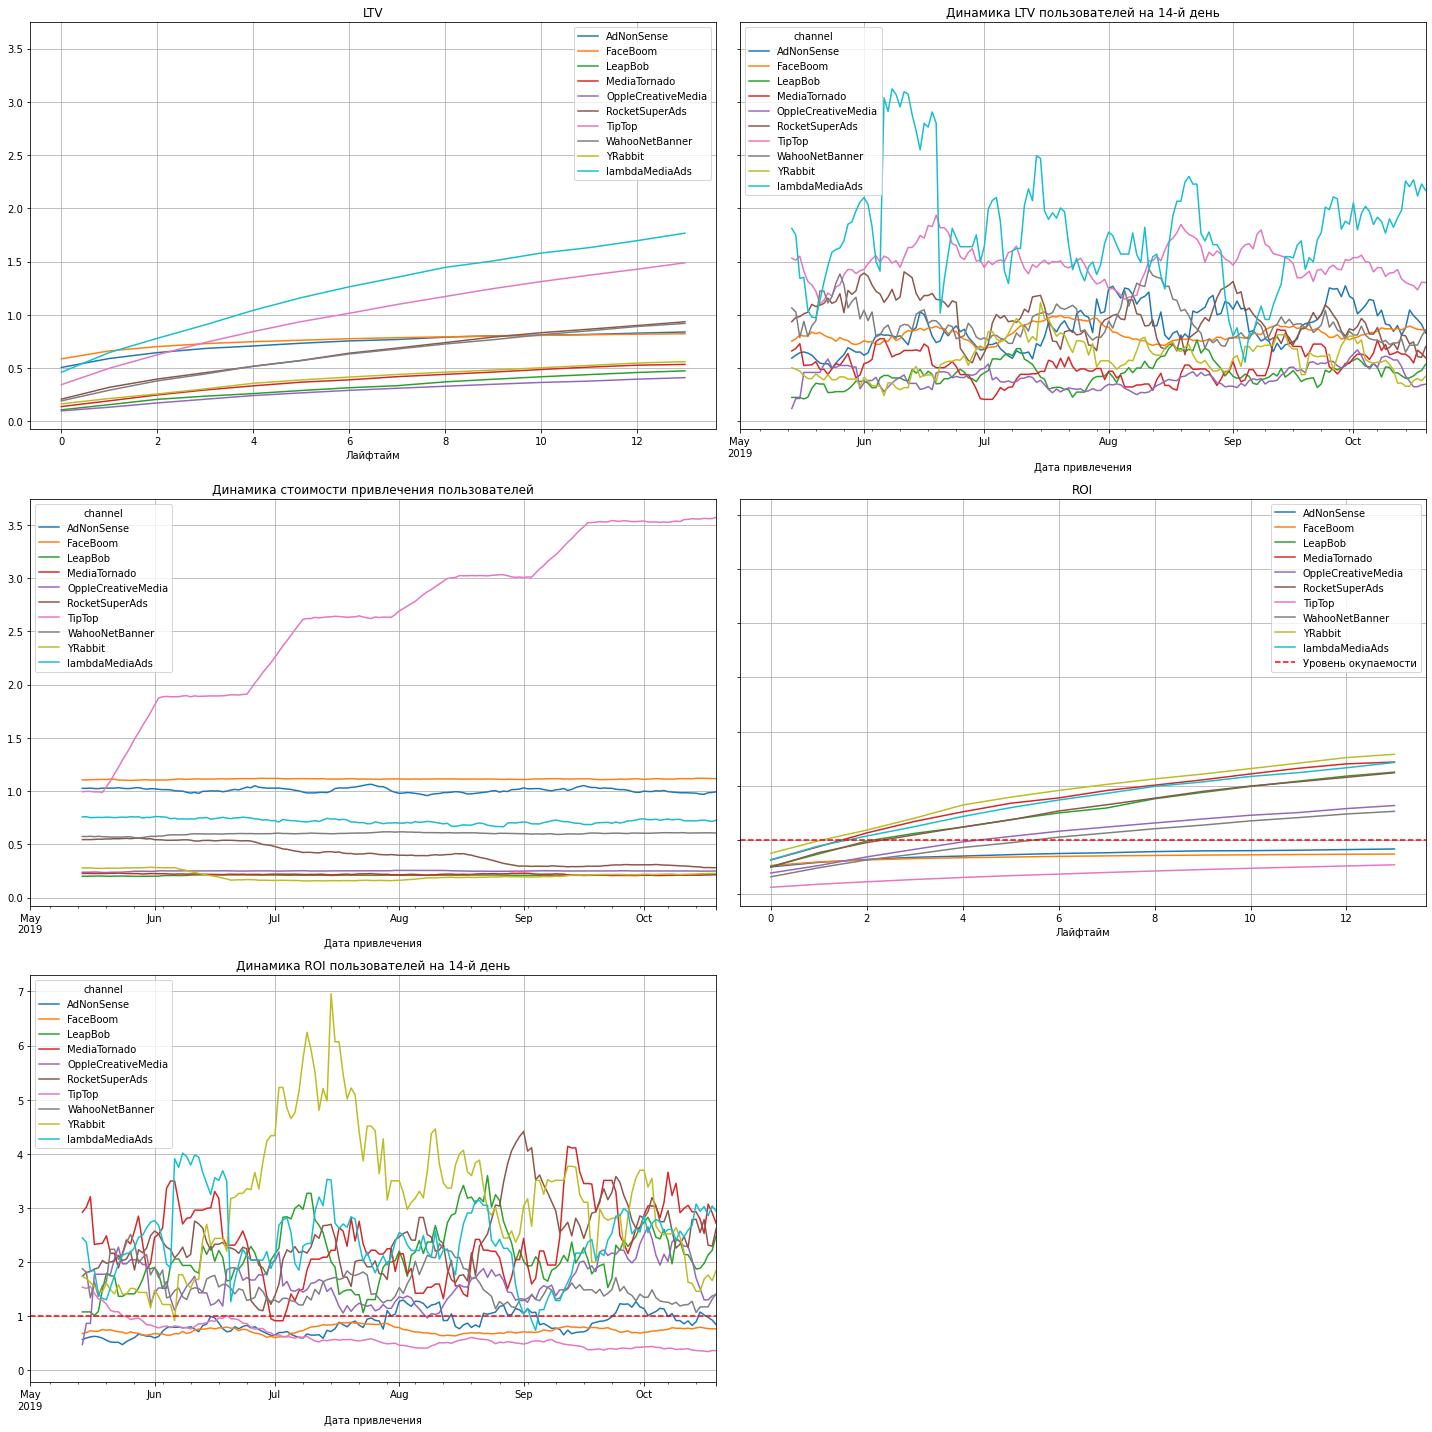

In [186]:
# смотрим окупаемость с разбивкой по источникам привлечения

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('channel!="organic"'), orders, observation_date, horizon_days, dimensions=dimensions)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

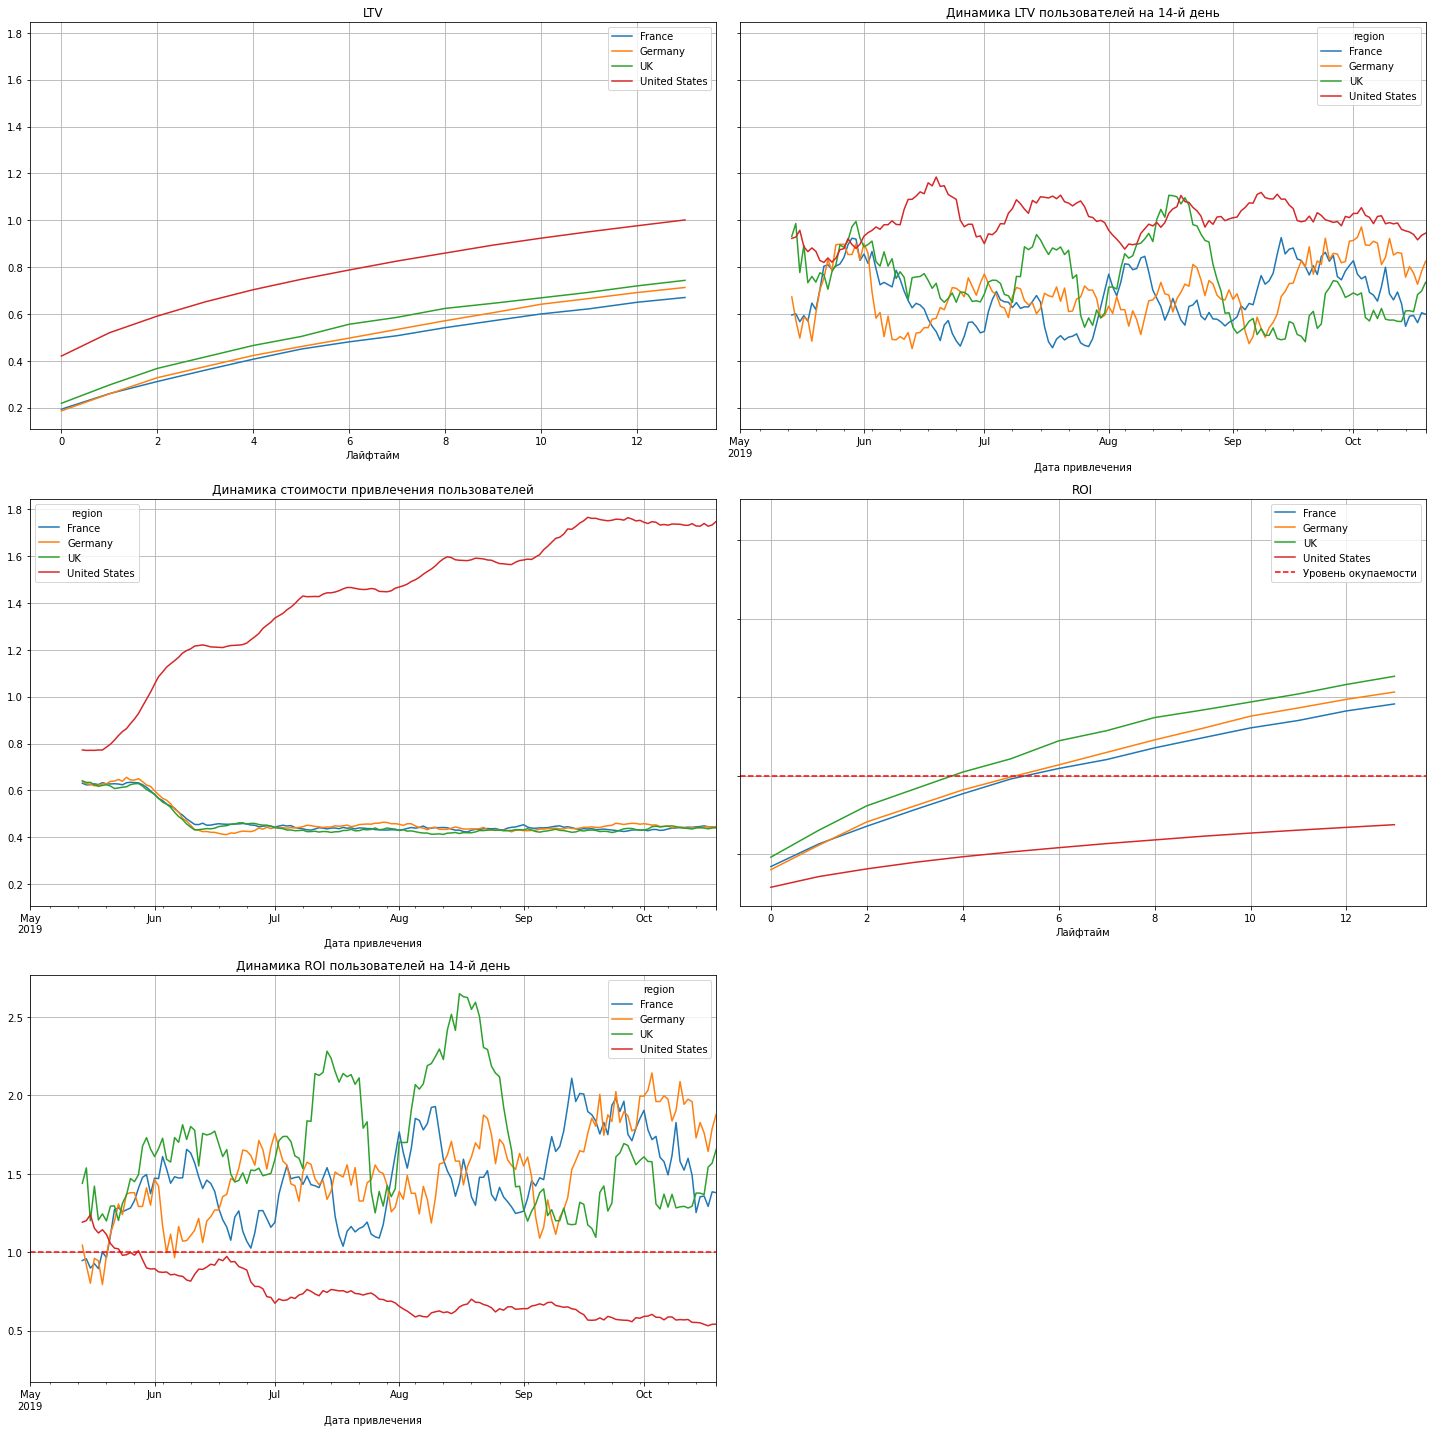

In [187]:
# смотрим окупаемость с разбивкой по регионам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('channel!="organic"'), orders, observation_date, horizon_days, dimensions=dimensions)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

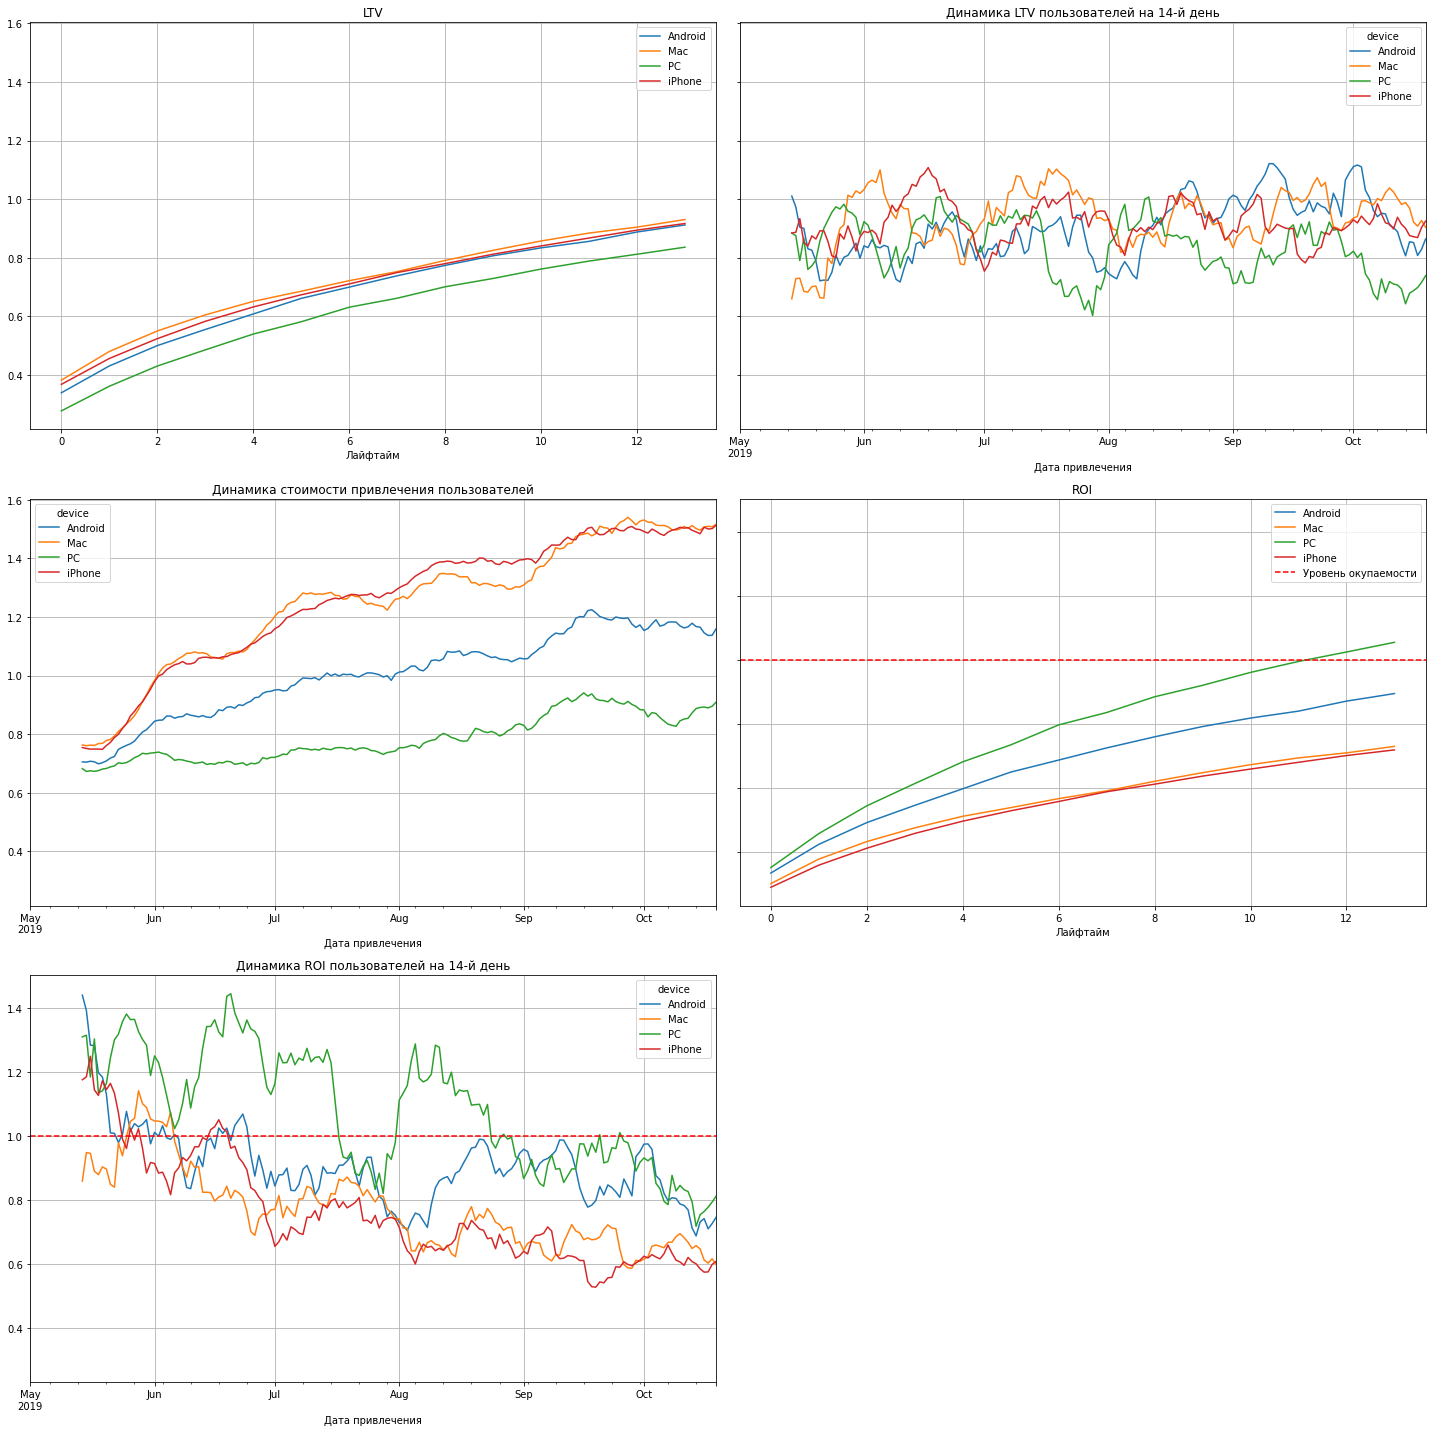

In [116]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('channel!="organic"'), orders, observation_date, horizon_days, dimensions=dimensions)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

Лучше всего конверсия пользователи Mac и iPhone, но эта группа хуже всего удерживаются.
Пользователи же PC и Android, которые хуже конверсируются, удерживаются лучше.
Схожая ситуация с разбивкой по странам - лучше всего конверсия пользователей из Америки, но они хуже всего удерживаются.
И с источниками привлечения - лучшая конверсия у FaceBoom, AdNonSence и lambdaMediaAds, худшее удержание - у FaceBoom и AdNonSence.


Изучив графики, мы видим что пользователи из США стабильно неокупаются, в то время как пользователи из Европы окупаются на 4-5 день. Высокий LTV пользоватлей из США нивелируется постоянным ростом стоимости привлечения (львиная доля которой уходит на привлечение пользователей TipTop). 

<a id="import"> </a>
# 6. Напишите выводы

- Выделите причины неэффективности привлечения пользователей.
- Сформулируйте рекомендации для отдела маркетинга.

<b>Общая информация</b>

Мы сформировали датасет profiles с информацией об уникальных пользователях. Датасет охватывает период с 01.05.2019 до 27.10.2019. В датасет вошла информация о канале привлечения пользователя, используемом устройстве, регионе и стоимости привлечения.

Сгруппировав данные о пользователях и стране, мы выяснили, что пользователи приходили из четырех стран - США, Германия, Великобритания и Франция. Абсолютное большинство пользователей приходят из Соединенных штатах - 100 002 пользователей из США против 50 006 пользователей суммарно из оставшихся стран. Несмотря на общее количество, процент платящих клиентов из США 6.9%, из других стран - около 4%.

Сгруппировав данные о пользователях и используемых устройствах, мы выяснили что пользователи пользуются четырьмя типами устройст - PC, Mac, устройства на Android и iPone. Больше всего пользователей используют iPhone (54 479), потом идут пользователи на Android (35 032), пользователей на Mac и PC примерно поровну - 30 042 и 30 455, соответственно. Процент платящих клиентов к общему количеству - больше всего Mac и iPhone (6.36% и 6.21%), следом идут пользователи Android и PC (5.85% и 5.05%, соответственно).

Выполнив группировку платящих пользователей по типу устройства и стране, мы выяснили закономерности:
- для Франции, Германии и Великобритании распредетение между типами устройств одинаковое - больше всего пользователей PC, потом Android, iPhone и Mac,
- для Америки - больше всего пользователей iPhone, потом - Mac и Android, меньше всего - PC.

Такой перекос для Америки объясним особенностями рынка - популярностью устройст apple и непопулярностью домашних компьютеров.


Для привлечения доступно 10 рекламных каналов и органический. Больше всего пользователей пришли из органического канала, Faceboom и TipTop. Проанализировав процент платящей аудитории, мы выяснили, что больше всего пользователей пришли из FaceBoom (12.2%), AdNonSense (11.34%) и lambdaMediaAds (10.47%). TipTop показал 9.6%, органический канал - 2.06%.

Каналы привлечения распределились между странами схожим с устройствами образом:
- мы можем объединить Францию, Германию и Великобританию, где самыми многочисленными каналами стали AdNonSense, WahooNetBanner, LeapBob и органический,
- в Америке самыми многочисленными каналами стали FaceBoom, TipTop и органический.

Для дальнейшей работы стоит иметь в виду особенности рынка этих стран и разделять их на две условные группы - Европа и Америка.

<b>Маркетинг</b>

Общая сумма средств выделенных на маркетинг - 105 497.30. Эти средства распределены неравномерно:
- больше всего выделено на TipTop (54 751.30), FaceBoom (32 445.60) и WahooNetBanner (5 151),
- на остальные источники выделяется в среднем по ~1 900.
Из предыдущего шага мы помним, что клиенты, приходящие из FaceBoom и TipTop - это клиенты из Америки, которые являются самыми многочисленными, но доля плятящих клиентов всего 6.9%. WahooNetBanner рассчитан на Европу, приносящую 11.89% платящих клиентов. Возможно, маркетинговому отделу стоит пересмотреть свою политику и больше денег выделять на WahooNetBanner и прочие сервисы, рассчитанные на привлечение клиентов из Европы.

Построенная нами таблица демонстрирует постоянный рост расходов на FaceBoom и TipTop. Расходы на остальные источники привлечения остается практически без именения.

Средняя стоимость привлечения по проекту - 0.70.

Самые дорогие каналы по средней стоимости привлечения: TipTop - 2.80, FaceBoom - 1.11, AdNonSense - 1.01.

Средняя стоимость привлечения по странам: Америка - 0.91, Европа - ~0.30.

Средняя стоимость привлечения по устройствам: Mac и iPone - 0.80, Android - 0.64, PC - 0.50.

Вывод: 
- меньше денег вкладывать в продвижение через TipTop (невыгодно, мало платящих пользователей),
- больше сосредоточиться на странах Европы - дешевле стоимость привлечения, больше платящих пользователей.

<b>Конверсия, удержание, LTV, окупаемость.</b>

Лучше всего конверсируются пользователи Mac и iPhone, но эта группа хуже всего удерживаются.
Пользователи же PC и Android, которые хуже конверсируются, удерживаются лучше.
Схожая ситуация с разбивкой по странам - лучше всего конверсируются пользователи из Америки, но они хуже всего удерживаются.
И с источниками привлечения - лучшая конверсия у FaceBoom, AdNonSence и lambdaMediaAds, худшее удержание - у FaceBoom, AdNonSence.


Изучив графики, мы видим что пользователи из США стабильно неокупаются, в то время как пользователи из Европы окупаются на 2-3 день. Высокий LTV пользоватлей из США нивелируется постоянным ростом стоимости привлечения (львиная доля которой уходит на привлечение пользователей TipTop). 

<b>Рекомендации для отдела маркетинга - перераспределить бюджет на маркетинг:</b>
1. основная статья расходов - это расходы на рекламу в TipTop и FaceBoom; обе соцсети направлены на американских пользователей. Доля платящих пользователей из Америки меньше, чем суммарно из Европы, конверсия пользователей из Америки лучше, но удержание хуже европейских. Часть рекламных денег лучше вложить в обслуживание приложений на Mac и iphone и промо-компании (как вариант - оповещение от приложений, рассылку или скидки на подписку. На LTV в динамике видны пики раз в один-два месяца - возможно это и есть моменты, когда пользователей видит сообщение о необходимости продлить подписку и вновь вспоминает про приложение). 

2. европейских пользователей не стоит списывать со счетов - при меньших, чем в Америку, вложениях в рекламу суммарно мы получаем выше процент платящих пользователей. Они дешевле в привлечении, быстрее окупаются (на 4 - 5 день), хуже конверсия, но лучше удержание.

Пропорциональное увеличение "европейского" бюджета на рекламу, уменьшение расходов на TipTop и FaceBoom и вложение этих средств в разработку приложения на ios и macos может суммарно принести больше дохода и поможет компании выйти в плюс.

<b>презентация:</b>

<https://github.com/ziadove/ya_project_6_communication/blob/72788b91fe5fa3e1b7deb064bf5fe9efa4c73180/presentation.pdf>